## Agent-based simulation of runners in a race

In [1]:
using Agents, Plots

In [2]:
@agent Runner GridAgent{2} begin
    exhaustion::Float64
    pace::Int
    viewdist::Int
end

### Step evolution logic
how many lanes ahead should runners be able to see when evaluating weights for each lane?

In [68]:
function getweights(runner::Runner, model::ABM)
    dim = spacesize(model)
    pos = runner.pos
    laneweights = zeros(dim[1])

    for i in 1:dim[1],
        j in range(pos[2]; length=min(runner.viewdist, dim[2]-pos[2]))
        laneweights[i] += (0.1
            * (length(ids_in_position((i,j), model)) - ((i,j) == pos))
            * runner.exhaustion)
    end

    return laneweights
end

getweights (generic function with 1 method)

should we allow runners to move directly to their preferred lane in a single step? (possibly more realistic agility when taking into account that the simulation space is discrete) or make them move one lane at a time? (possibly higher performance, more continuous(?) simulation)

In [71]:
function agent_step!(runner::Runner, model::ABM)
    lane, = runner.pos
    laneweights = getweights(runner, model)
    optlane = all(p -> p == laneweights[1], laneweights) ? lane : argmin(laneweights)

    # the debate: jump to or step towards new lane
    lanedist = optlane-lane
    delta = (lanedist,
        lanedist == 0 ? runner.pace : min(floor(Int, runner.pace/abs(lanedist)), 1))
    #delta = (sign(lanedist), runner.pace)

    move_agent!(runner, runner.pos .+ delta, model)
end

agent_step! (generic function with 1 method)

### Running the simulation

In [29]:
function racemodel()
    dimensions = (10, 100)
    road = GridSpace(dimensions; metric=:manhattan)

    properties = Dict("water_point" => (dimensions[1], dimensions[2] / 2))
    model = ABM(Runner, road; properties)

    exhaustion::Float64 = 0.2
    pace = 4
    viewdist = 10
    add_agent!((5, 1), model, exhaustion, pace, viewdist)

    return model
end

racemodel (generic function with 1 method)

In [72]:
model = racemodel()

StandardABM with 1 agents of type Runner
 space: GridSpace with size (10, 100), metric=manhattan, periodic=true
 scheduler: fastest
 properties: water_point

### Visualisation

[ Info: Saved animation to /home/codeo/stats/code/tmp.gif


Plots.AnimatedGif("/home/codeo/stats/code/tmp.gif")
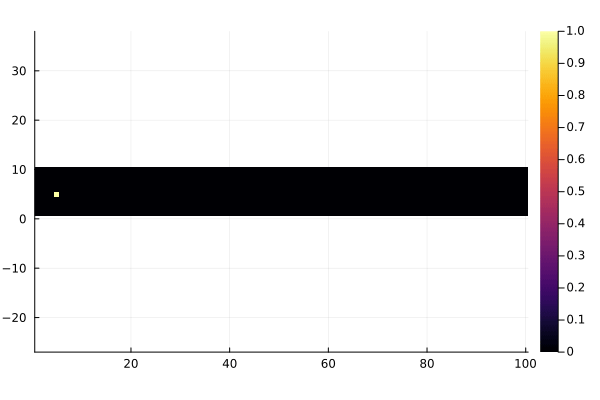

In [73]:
@gif for i in 1:20
    step!(model, agent_step!, 1)

    agentcounts = map(p -> length(ids_in_position(p, model)), positions(model))
    heatmap(agentcounts, aspect_ratio = :equal)
end